# BHARADWAJ VADUGURU(1001761106)

In [1]:
from bs4 import BeautifulSoup
import requests
import re
import sqlite3
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

# 1. Rottentomatoes review scrapping

In [2]:
def get_top50_movies_rottentomatoes(count=50):
    url = 'https://www.rottentomatoes.com/top/bestofrt/'# Url of given website
    user_agent = {'User-agent': 'Mozilla/5.0'}
    response = requests.get(url, headers = user_agent)# request is made to the given website and the status code 200 is returned if it is a succesful request.
    soup = BeautifulSoup(response.text, 'lxml')# created beautiful soup reference 
    a_tags = soup.select('table td a.articleLink')#converging the  entire html of the website to our requirement and stores in datastructure called list so that we can perform various operatio.
    links = [a.attrs.get('href') for a in a_tags]#finding the content inside the href attribute
    titles = [a.text.replace('\n', '').strip() for a in a_tags]#finding the text inside the a tag
    
    years = [title[len(title)-6:].replace('(', '').replace(')', '') for title in titles]#finding the years of aparticular movie
    titles = [title[:len(title)-6].strip() for title in titles]#finding the title of the movie
    
    top_movies = [
        {
            'movie_title': titles[index],
            'year': years[index],
            'link': links[index],
        }
        for index in range(len(titles)) if index < count
    ]#storing in list of dictionaries so that we can easily access corresponding titles, years,link  whenour  it is required
    
    return top_movies#RETURNS A LIST CONTAING MOVIE TITLE,YEAR,SUBLINK


def get_movie_genres_rottentomatoes(link):
    url = 'https://www.rottentomatoes.com{}'.format(link)#request is made to find genre of the movie by using sublink
    user_agent = {'User-agent': 'Mozilla/5.0'}
    response = requests.get(url, headers = user_agent)#response is returned for a given request
    soup = BeautifulSoup(response.text, 'lxml')#soup object is made using lxml format
    return set(genre.strip().lower() for genre in soup.select('ul.content-meta div.genre')[0].text.replace('\n', '').replace('and', ',').split(','))#returns genres using set so that it cant have any duplicates.


def get_movie_reviews_rottentomatoes(link):
    def getReviews(endCursor):
        r = requests.get(f"https://www.rottentomatoes.com/napi/movie/{movieId}/reviews/user",
        params = {
            "direction": "next",
            "endCursor": endCursor,
            "startCursor": ""
        })
        return r.json()
    url = f"https://www.rottentomatoes.com{link}/reviews?type=user" #url of the given website
    r = requests.get(url)#request is made and response is stored
    data = json.loads(re.search('movieReview\s=\s(.*);', r.text).group(1))#searching the  movies through given regular expression
    movieId = data["movieId"]#storing movieids in a variable named movieId
    
    reviews = []
    result = {}
    for i in range(0, 5):
        result = getReviews(result["pageInfo"]["endCursor"] if i != 0  else "")
        reviews.extend([t for t in result["reviews"]])
    
    return [item['review'].replace('\n', '').replace(',', '') for item in reviews]#returns reviews


def get_top_movies_reviews_rottentomatoes():
    top_movies = get_top50_movies_rottentomatoes()
    data = []
    
    for top_movie in top_movies:
        year = top_movie.get('year', None)#getting the year of the particular movie by accessing the list of dictionary
        title = top_movie.get('movie_title', None)#getting the title of particular movie
        link = top_movie.get('link', None)#getting the sublink of given movie
        reviews = get_movie_reviews_rottentomatoes(link)#getting the reviews of particular movie.
        genres = get_movie_genres_rottentomatoes(link)#getting the genres of particular movie

        for review in reviews:
            data.append([title, year, review, genres, 'rottentomatoes'])#Appending all the attributes of a movie to a list
            
    return data

In [3]:
total_reviews_rottentomatoes = get_top_movies_reviews_rottentomatoes()
print(f'scrapped {len(total_reviews_rottentomatoes )} Rottentomatoes reviews from top 50 movies')

scrapped 2500 Rottentomatoes reviews from top 50 movies


# 2. Metacritic review scrapping

In [4]:
def get_top50_movies_metacritic(count=50):
    url = 'https://www.metacritic.com/browse/movies/score/metascore/all/filtered?view=detailed'#url of given website
    user_agent = {'User-agent': 'Mozilla/5.0'}#we need to use a user agent here, because metacritics does not accept bots
    response = requests.get(url, headers = user_agent)#finding the response
    soup = BeautifulSoup(response.text, 'lxml')#creating the soup object
    links = [a.attrs.get('href') for a in soup.select('table.clamp-list td.clamp-summary-wrap a.title')]#finding all the links of metacritic website
    titles = [a.text for a in soup.select('table.clamp-list td.clamp-summary-wrap a.title')]#finding all the titles

    years = [re.findall('\d{4}', span.text) for span in soup.select('table.clamp-list td div.clamp-details')]#finding all the years
    years = [year[0] if year else None for year in years]#Exteacting further to get the required year
    
    top_movies = [
        {
            'movie_title': titles[index],
            'year': years[index],
            'link': links[index],
        }
        for index in range(len(titles)) if index < count
    ]#creating the list of dictionaries
    
    return top_movies#return the top 50 movies


def get_movie_genres_metacritic(link):
    url = f'https://www.metacritic.com{link}'#getting the link of the given movie
    user_agent = {'User-agent': 'Mozilla/5.0'}#useragents to be considered 
    response = requests.get(url, headers = user_agent)#finding the response 
    soup = BeautifulSoup(response.text, 'lxml')#creating the soup object
    genres = set()#set can be used to remove the duplicates

    for span in soup.select('div.genres span')[1:]:
        for genre in span.text.strip().split(','):
            genres.add(genre.strip().lower())
            
    return genres


def get_movie_reviews_metacritic(link):
    url = f'https://www.metacritic.com{link}/user-reviews'#getting the link of the given website
    user_agent = {'User-agent': 'Mozilla/5.0'}#useragents to be considered
    response = requests.get(url, headers = user_agent)#finding the response 
    soup = BeautifulSoup(response.text, 'lxml')#creating the bs reference
    reviews = [div.text.replace('\n', '').strip() for div in soup.select('div.user_reviews div.summary')]#finding the reviews by mining the data further
    return reviews#return the reviews


def get_top_movies_reviews_metacritic():
    top_movies_metacritic = get_top50_movies_metacritic()
    data = []
    
    for top_movie in top_movies_metacritic:
        year = top_movie.get('year', None)#finding the year of aparticular movie
        title = top_movie.get('movie_title', None)#finding the title of aparticular movie
        link = top_movie.get('link', None)#finding the link of aparticular movie
        reviews = get_movie_reviews_metacritic(link)#finding the review of aparticular movie
        genres = get_movie_genres_metacritic(link)#finding the genre of aparticular movie

        for review in reviews:
            data.append([title, year, review, genres, 'metacritic'])
            
    return data # return all the movie info of metacritic website

In [5]:
total_reviews_metacritic = get_top_movies_reviews_metacritic()
print(f'scrapped {len(total_reviews_metacritic)} Metacritic reviews from top 50 movies')

scrapped 1459 Metacritic reviews from top 50 movies


# 3. IMDB review Scrapping

In [6]:
def get_top50_movies_imdb(number=50):
    """
    Get Top movies from IMDB
    """
    url = 'http://www.imdb.com/chart/top'#url of the given website
    response = requests.get(url)#response for the given website
    soup = BeautifulSoup(response.text, 'lxml')#creating the soup object
    movies = soup.select('td.titleColumn')#finding the movies of given website
    links = [a.attrs.get('href') for a in soup.select('td.titleColumn a')]#finding the links of given website
    crew = [a.attrs.get('title') for a in soup.select('td.titleColumn a')]#finding the crew of given website
    ratings = [b.attrs.get('data-value') for b in soup.select('td.posterColumn span[name=ir]')]#finding the ratings of given website
    votes = [b.attrs.get('data-value') for b in soup.select('td.ratingColumn strong')]#finding the votes of given website
    top_movies = []

    for index in range(0, number):
        movie_string = movies[index].get_text()#getting the name of the movie 
        movie = (' '.join(movie_string.split()).replace('.', ''))#extracting the name of the movie 
        movie_title = movie[len(str(index))+1:-7]#finding the movie title of the movie
        year = re.search('\((.*?)\)', movie_string).group(1)#finding the year of particular movie
        place = movie[:len(str(index))-(len(movie))]#finding the place of particular movie
        data = {"movie_title": movie_title,
                "year": year,
                "place": place,
                "star_cast": crew[index],
                "rating": ratings[index],
                "vote": votes[index],
                "link": links[index]}
        top_movies.append(data)
    return top_movies #returns top 50 movies 


def get_movie_reviews_imdb(link):
    """
    Get movies reviews using link
    """
    
    url = f'https://www.imdb.com{link}reviews'#finding the url of given website
    response = requests.get(url)#finding the response
    soup = BeautifulSoup(response.text, 'lxml')#creating the soup object
    reviews = [] 
    
    for review in soup.select('div.lister-item-content'):
        review_content = ' '.join(tag.text for tag in review.select('div.content'))
        review_content = re.sub(r'\d+ out of \d+.*$', '', review_content).strip().replace('\n', '')
        review_content = re.sub(r'\d+ out of \d+.*$', '', review_content).strip().replace('\n', '')
        reviews.append(review_content) #mining the data further to get the exact review_content
        
    return reviews#return the reviews


def get_movie_genres_imdb(link):
    """
    Scrap movie genres
    """
    url = f'https://www.imdb.com{link}'#finding the url 
    response = requests.get(url)#finding the response
    soup = BeautifulSoup(response.text, 'lxml')#creating the soup object
    
    genres = [a.text for a in soup.select('div.article div.see-more')][-1]#finding the genres
    genres = genres.replace('Genres:', '').replace('\n', '').split('\xa0|')#extracting further to get the exact genres
    return set(genre.lower().strip() for genre in genres) #return genres without having duplicates


def get_top_movies_reviews_imdb():
    top_movies_imdb = get_top50_movies_imdb()
    data = []
    
    for top_movie in top_movies_imdb:
        year = top_movie.get('year', None)#finding the year of particular movie
        title = top_movie.get('movie_title', None)#finding the title of a particular movie
        link = top_movie.get('link', None)#finding the link of the particular movie
        rating = top_movie.get('rating', None)#finding the rating of the movie.
        reviews = get_movie_reviews_imdb(link)#finding all the reviews of the movie
        genres = get_movie_genres_imdb(link)#finding genres of the movie

        for review in reviews:
            data.append([title, year, review, genres, 'imdb'])
            
    return data#return all the movie_info of imdb 

In [7]:
total_reviews_imdb = get_top_movies_reviews_imdb()
print(f'scrapped {len(total_reviews_imdb)} IMDB reviews from top 50 movies')

scrapped 1247 IMDB reviews from top 50 movies


# Saving to csv file

In [36]:

total_size = 1000#to have uniformity we considered 1000 reviews across all the websites

with open('bharadwajvaduguru_reviews.csv', 'w',encoding='utf-8') as f:
    f.write('title,year,review,review_length,genres,source\n')#creating all the attributes as  columns
    for review in total_reviews_rottentomatoes[:total_size] + total_reviews_metacritic[:total_size] + total_reviews_imdb[:total_size]:
        title, year, review, genres, source = review
        genres = ':'.join(genres)#storing genre information
        title = title.replace(',', ' ')#storing title information
        review = review.replace('\n', '').replace(',', '')#storing review information
        review_length = len(review)#storing the length of the review
        f.write(f'{title},{year},{review},{review_length},{genres},{source}\n')#writing it to csv file

# Saving to db

In [37]:
data = []
with open('bharadwajvaduguru_reviews.csv', 'r',encoding='utf-8') as f:
    is_header = True
    for index, line in enumerate(f.readlines()):
        if is_header:
            is_header = False
            continue
            
        items = line.strip().split(',')
        if len(items) != 6:
            continue
        data.append(items)

In [38]:
df = pd.DataFrame(data, columns=['title', 'year', 'review', 'review_length', 'genres', 'source'])#creating a dataframe

df['year'] = df['year'].astype(int) #converting it to int
df['review_length'] = df['review_length'].astype(int)#converting it to int

In [39]:
df.head()

,title,year,review,review_length,genres,source
0,Black Panther,2018,It was absolutely appaling!!!!! I have never b...,155,fantasy:action:adventure,rottentomatoes
1,Black Panther,2018,Best movie of all time? Best drama of all tim...,126,fantasy:action:adventure,rottentomatoes
2,Black Panther,2018,Black panther lived up to the height,36,fantasy:action:adventure,rottentomatoes
3,Black Panther,2018,Not sure what all the hype was about. This mov...,91,fantasy:action:adventure,rottentomatoes
4,Black Panther,2018,R.I.P. Chadwick Boseman,23,fantasy:action:adventure,rottentomatoes


In [40]:
# Create a sqlite3 database called MovieReviewDatabase
conn = sqlite3.connect('MovieReviewDatabase.db')
c = conn.cursor()

# Saving data to a table names MovieReviewTable
df.to_sql('MovieReviewTable', conn, if_exists='replace', index = False)

# 1. Comparaing review style across the 3 websites

In [13]:
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import nltk
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline
sns.set()

from collections import defaultdict

In [14]:
stop_words = set(stopwords.words('english')) | set(('film', 'movie'))
replace_signs = re.compile('[/(){}\[\]\|@,;]')    # Remove characteris from dict 
replace_digit = re.compile('[^0-9a-z #+_]')       # Remove digits from dict
words = set(nltk.corpus.words.words())

In [15]:
print(f'Datafram shape {df.shape}')

Datafram shape (2950, 6)


Text(0, 0.5, 'Frequency')

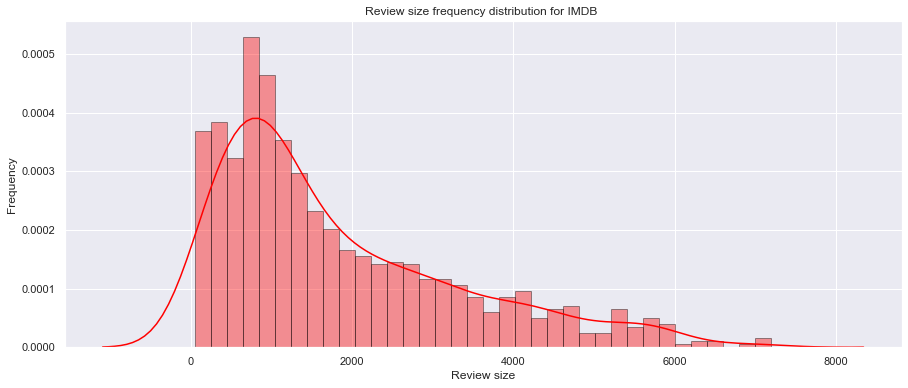

In [17]:
plt.figure(figsize=(15,6))
sns.distplot(
    df[df.source == 'imdb']['review_length'], 
    hist=True, 
    kde=True, 
    bins=int(180/5), 
    color = 'red',
    hist_kws={'edgecolor':'black'}
)

plt.title('Review size frequency distribution for IMDB ')
plt.xlabel('Review size')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

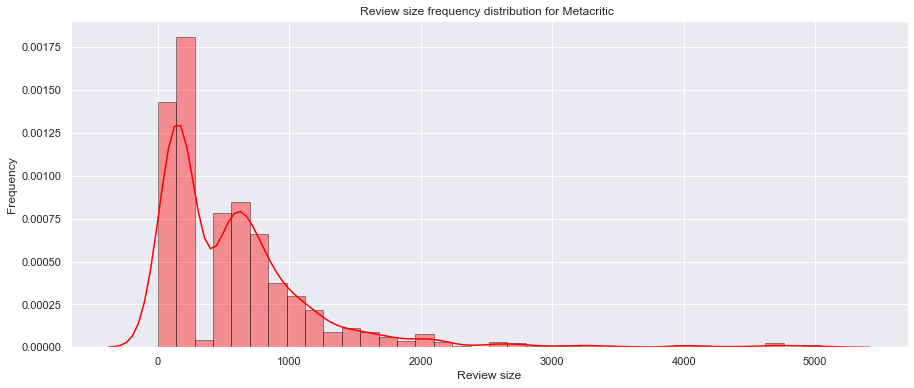

In [18]:
plt.figure(figsize=(15,6))
sns.distplot(
    df[df.source == 'metacritic']['review_length'], 
    hist=True, 
    kde=True, 
    bins=int(180/5), 
    color = 'red',
    hist_kws={'edgecolor':'black'}
)

plt.title('Review size frequency distribution for Metacritic ')
plt.xlabel('Review size')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

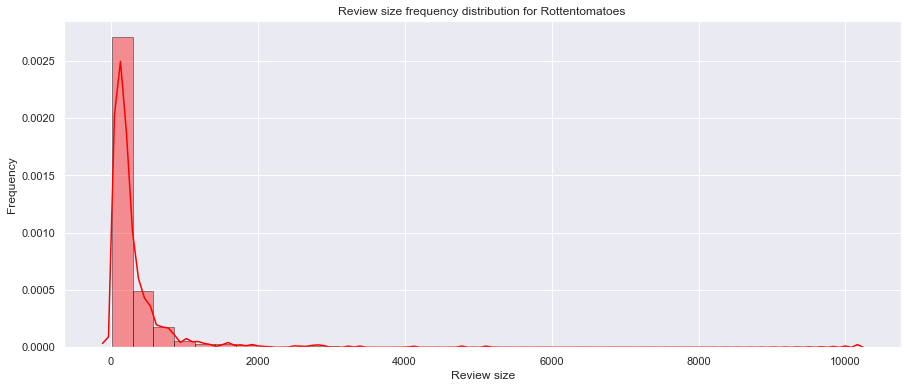

In [19]:
plt.figure(figsize=(15,6))
sns.distplot(
    df[df.source == 'rottentomatoes']['review_length'], 
    hist=True, 
    kde=True, 
    bins=int(180/5), 
    color = 'red',
    hist_kws={'edgecolor':'black'}
)

plt.title('Review size frequency distribution for Rottentomatoes ')
plt.xlabel('Review size')
plt.ylabel('Frequency')

Text(0, 0.5, 'Density')

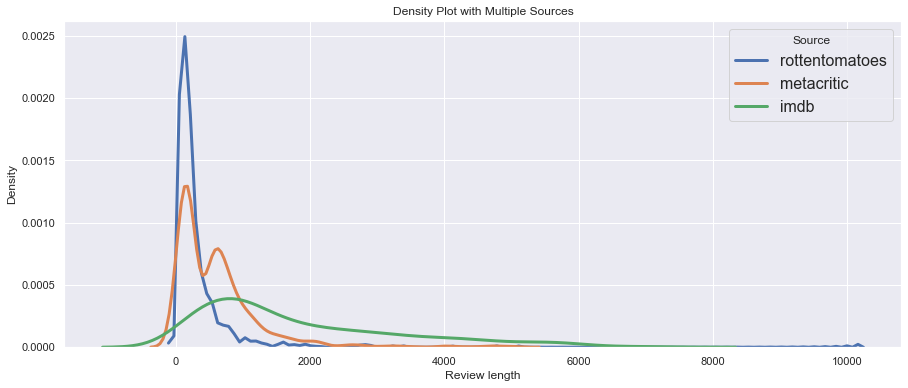

In [20]:

sources = list(df.source.unique())

plt.figure(figsize=(15,6))
# Iterate through the three moviesites
for source in sources:
    
    subset = df[df['source'] == source]
    
    # Draw the density plot
    sns.distplot(subset['review_length'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = source)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Source')
plt.title('Density Plot with Multiple Sources')
plt.xlabel('Review length')
plt.ylabel('Density')

In [21]:
# Helpers functions to process text
def tokenize_remove_punctuations(sentences):               
    wordfreq = defaultdict(lambda : 0)
    for sentence in sentences:
        words = nltk.RegexpTokenizer(r"\w+").tokenize(sentence.lower())                                                 # len(word)>2   
        for word in words: 
            if word in stop_words or word.isdigit() or len(word) < 3 or not word.isalpha():
                continue
            wordfreq[word] += 1
    return wordfreq 


def sort_words_freq(frequencies):                        
    return dict(sorted(frequencies.items(), key=lambda word: word[1], reverse=True))
 
def delete_threshold(wordfreq): 
    return {word: frequency for word, frequency in wordfreq.items() if frequency > 5}
  
def vector_matrix_review(X):
    sentence_vectors = []
    for txt,i  in zip(X,y):
        sentence_tokens = nltk.RegexpTokenizer(r"\w+").tokenize(txt)
        sent_vec = []
        for token in wordfreq_sorted_X:   
            if token in sentence_tokens:
                sent_vec.append(1)
            else:
                sent_vec.append(0)
        sentence_vectors.append([sent_vec,i])
    return sentence_vectors 

In [22]:
reviews_imdb = df[df.source == 'imdb']
reviews_metacritic = df[df.source == 'metacritic']
reviews_rottentomatoes = df[df.source == 'rottentomatoes']

In [23]:
word_frequency_imdb = tokenize_remove_punctuations(reviews_imdb['review'])
word_frequency_metacritic = tokenize_remove_punctuations(reviews_metacritic['review'])
word_frequency_rottentomatoes = tokenize_remove_punctuations(reviews_rottentomatoes['review'])

In [24]:
print(f'\nTop 50 words in IMDB reviews are :\n{list(word_frequency_imdb)[:50]}')
print(f'\nTop 50 words in Rottentomatoes reviews are :\n{list(word_frequency_rottentomatoes)[:50]}')
print(f'\nTop 50 words in Metacritic reviews are :\n{list(word_frequency_metacritic)[:50]}')


Top 50 words in IMDB reviews are :
['shawshank', 'redemption', 'written', 'directed', 'frank', 'darabont', 'adaptation', 'stephen', 'king', 'novella', 'rita', 'hayworth', 'starring', 'tim', 'robbins', 'morgan', 'freeman', 'portrays', 'story', 'andy', 'dufresne', 'banker', 'sentenced', 'two', 'life', 'sentences', 'state', 'prison', 'apparently', 'murdering', 'wife', 'lover', 'finds', 'tough', 'going', 'solace', 'friendship', 'forms', 'fellow', 'inmate', 'ellis', 'red', 'redding', 'things', 'start', 'pick', 'warden', 'job', 'befitting', 'talents']

Top 50 words in Rottentomatoes reviews are :
['absolutely', 'appaling', 'never', 'bored', 'ashamed', 'marvel', 'entire', 'life', 'dreadful', 'would', 'watch', 'recommend', 'best', 'time', 'drama', 'lost', 'collective', 'minds', 'smacks', 'social', 'justice', 'sympathy', 'black', 'panther', 'lived', 'height', 'sure', 'hype', 'kind', 'boring', 'times', 'chadwick', 'boseman', 'average', 'superhero', 'nothing', 'super', 'special', 'masterpiece', 

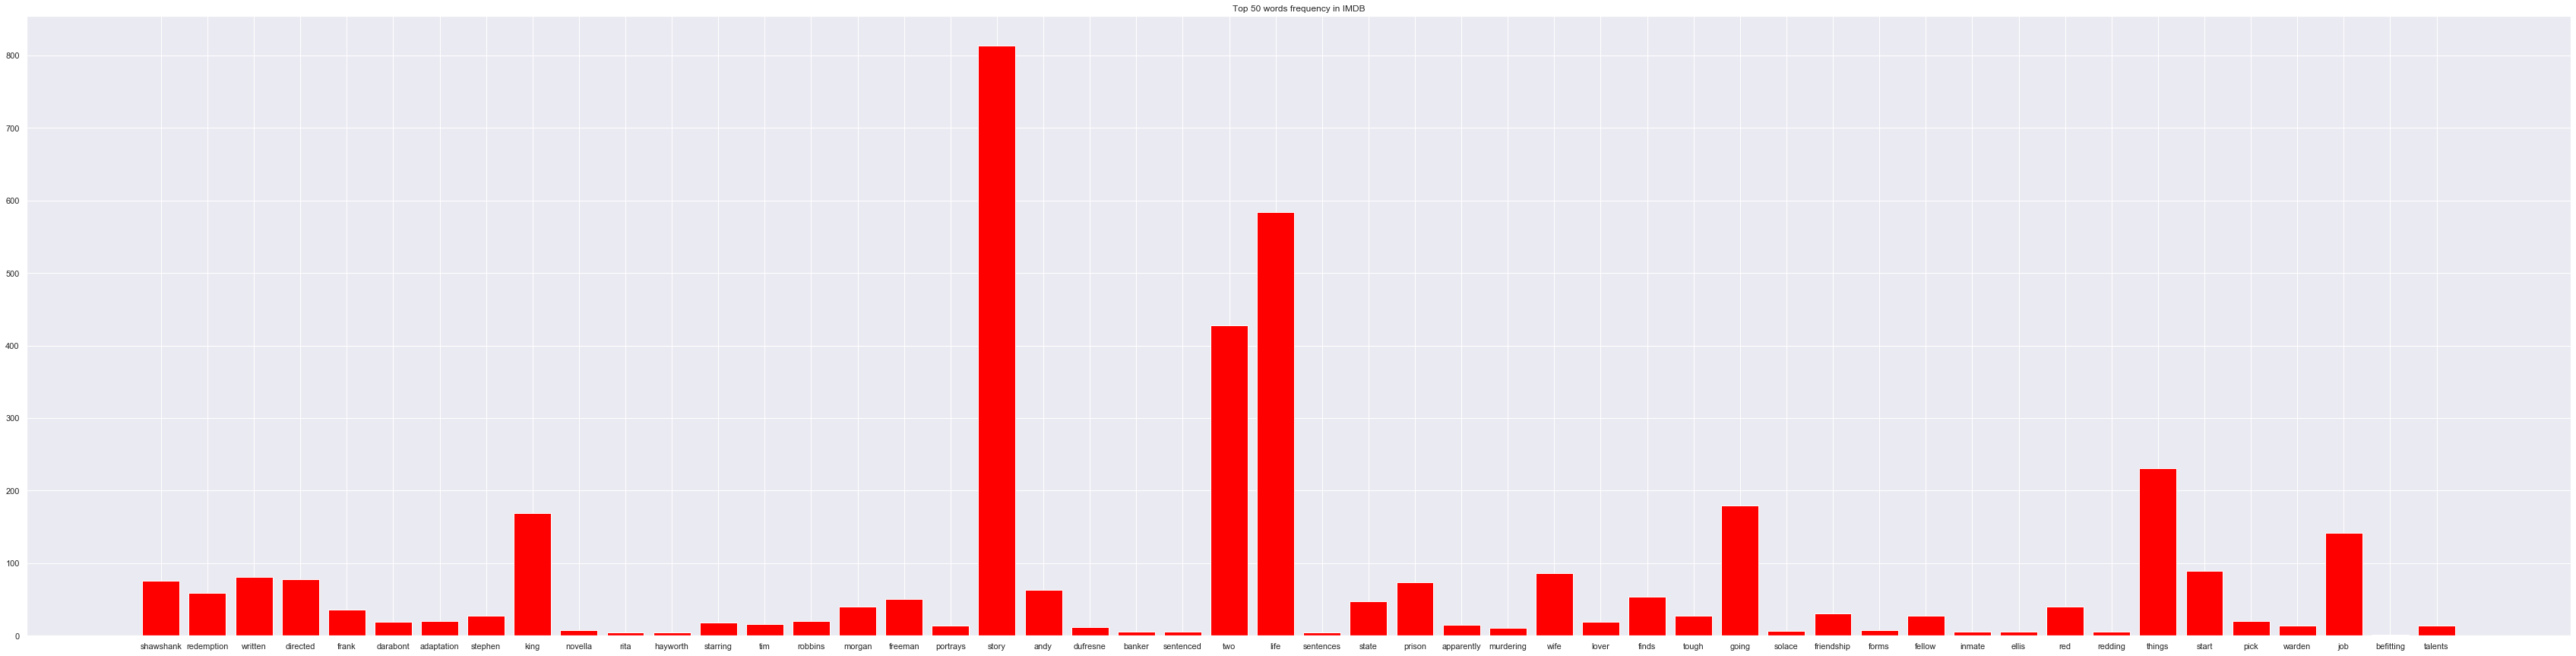

In [26]:
sample_size = 50
plt.figure(figsize=(60,15))

plt.bar( 
    list(word_frequency_imdb.keys())[:sample_size],
    list(word_frequency_imdb.values())[:sample_size],
    color='red'
)
plt.title('Top 50 words frequency in IMDB')
plt.show()

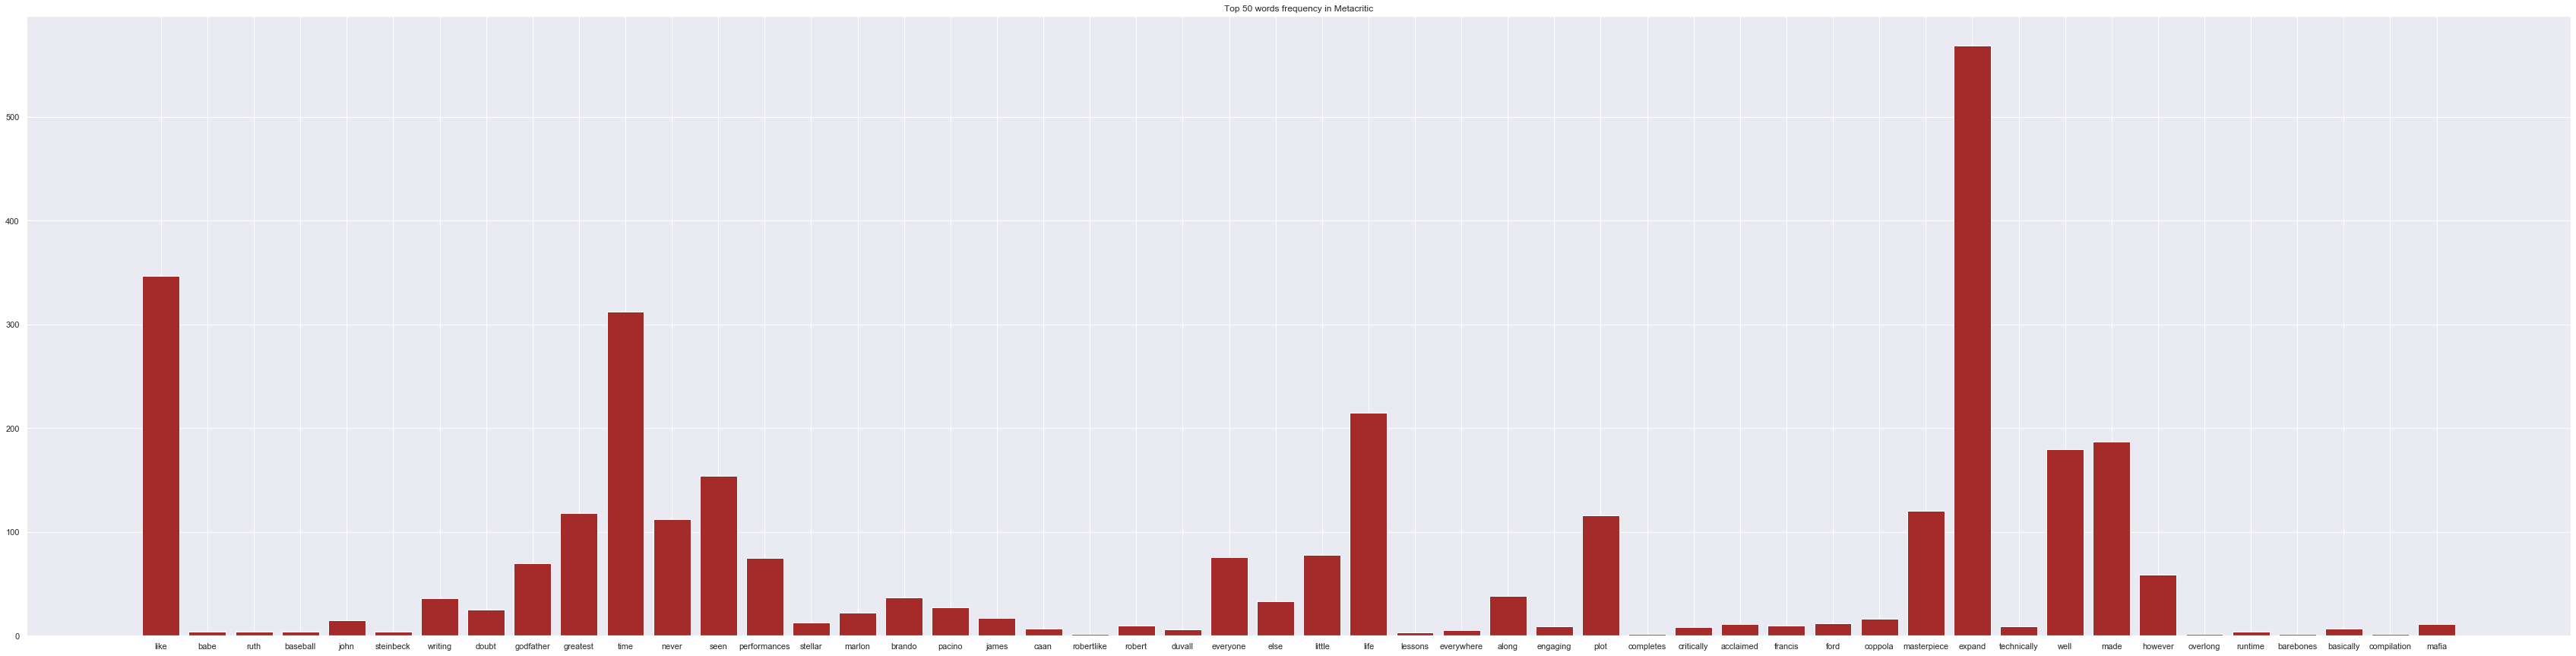

In [27]:
sample_size = 50
plt.figure(figsize=(60,15))

plt.bar( 
    list(word_frequency_metacritic.keys())[:sample_size],
    list(word_frequency_metacritic.values())[:sample_size],
    color='brown'
)
plt.title('Top 50 words frequency in Metacritic')
plt.show()

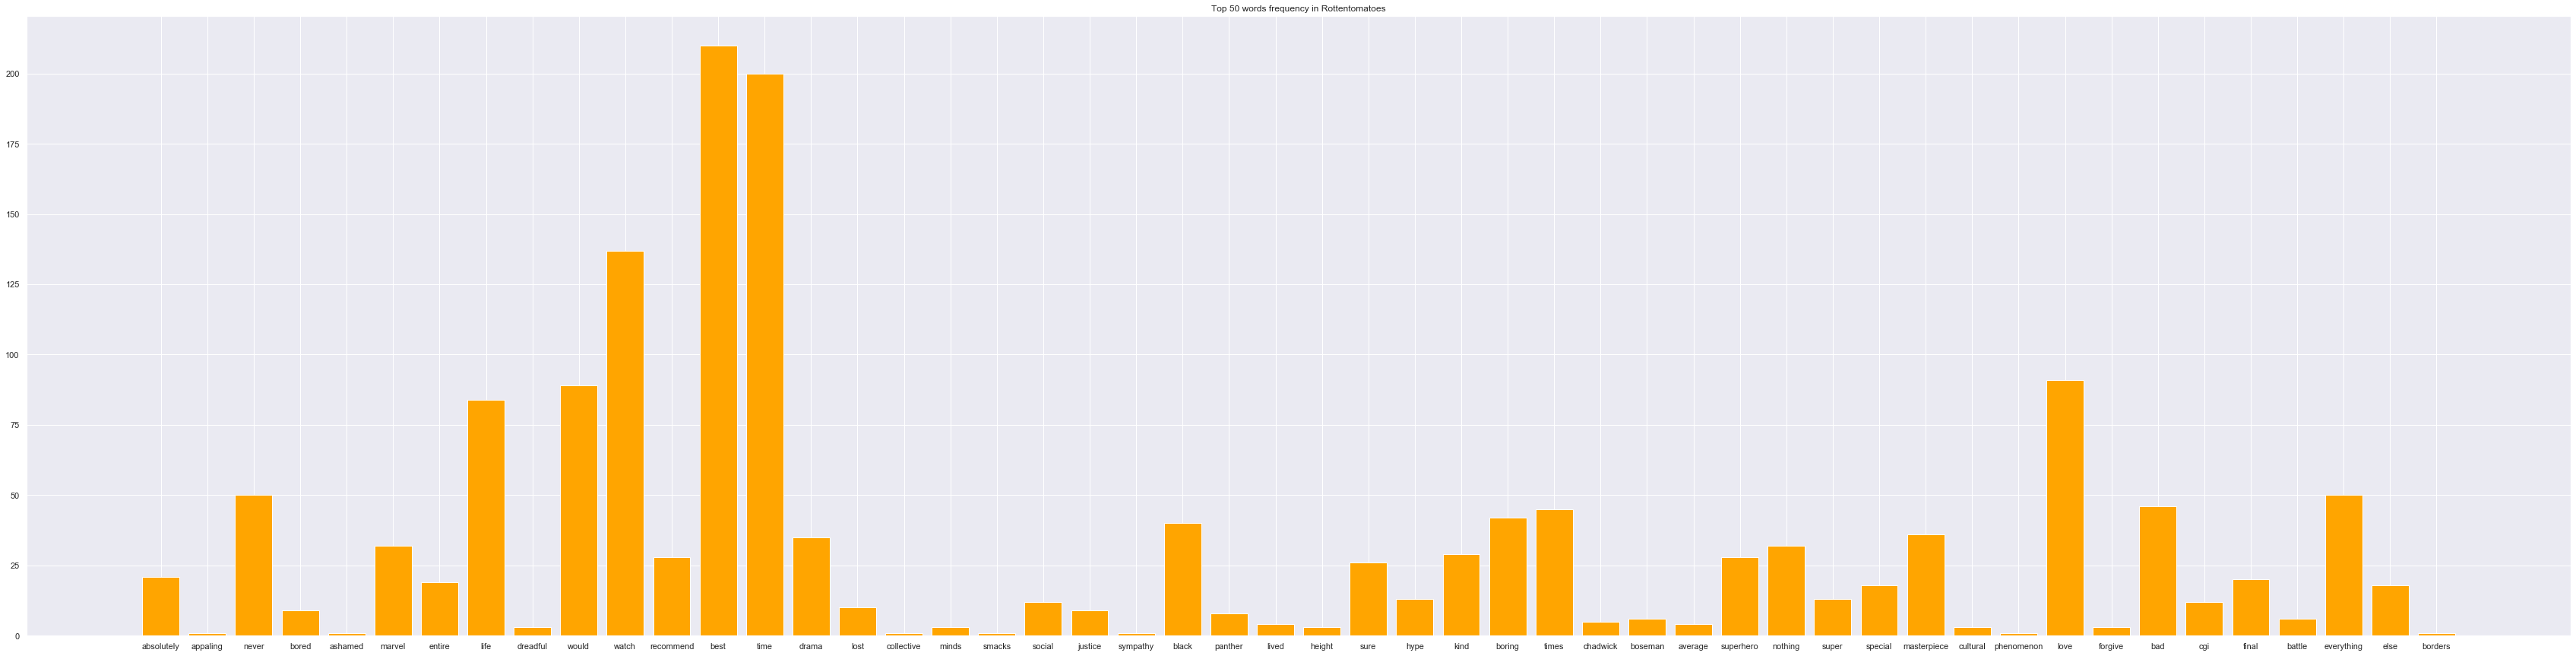

In [28]:
sample_size = 50
plt.figure(figsize=(60,15))

plt.bar( 
    list(word_frequency_rottentomatoes.keys())[:sample_size],
    list(word_frequency_rottentomatoes.values())[:sample_size],
    color='orange'
)
plt.title('Top 50 words frequency in Rottentomatoes')
plt.show()

# Cosine similarity between reviews across sources

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [30]:
imdb_document = ' '.join(df[df.source == 'imdb']['review'].values)
metacritic_document = ' '.join(df[df.source == 'metacritic']['review'].values)
rottentomatoes_document = ' '.join(df[df.source == 'rottentomatoes']['review'].values)

documents = [imdb_document, metacritic_document, rottentomatoes_document]

In [31]:


count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer = CountVectorizer()
sparse_matrix = count_vectorizer.fit_transform(documents)


doc_term_matrix = sparse_matrix.todense()
word2vector = pd.DataFrame(
        doc_term_matrix, 
        columns=count_vectorizer.get_feature_names(), 
        index=['imdb', 'metacritic', 'rottentomatoes']
)

print(cosine_similarity(word2vector, word2vector))

[[1.         0.98221153 0.97927426]
 [0.98221153 1.         0.98860387]
 [0.97927426 0.98860387 1.        ]]


#  Comparing Movie genre across websites

In [32]:
imdb_document = ' '.join(genre.replace(':', ' ') for genre in df[df.source == 'imdb']['genres'].values)
metacritic_document = ' '.join(genre.replace(':', ' ') for genre in  df[df.source == 'metacritic']['genres'].values)
rottentomatoes_document = ' '.join(genre.replace(':', ' ') for genre in  df[df.source == 'rottentomatoes']['genres'].values)

genres_documents = [imdb_document, metacritic_document, rottentomatoes_document]

In [33]:
count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer = CountVectorizer()
sparse_matrix = count_vectorizer.fit_transform(genres_documents)

doc_term_matrix = sparse_matrix.todense()
word2vector = pd.DataFrame(
        doc_term_matrix, 
        columns=count_vectorizer.get_feature_names(), 
        index=['imdb', 'metacritic', 'rottentomatoes']
)

print(cosine_similarity(word2vector, word2vector))

[[1.         0.8484581  0.82795684]
 [0.8484581  1.         0.65040658]
 [0.82795684 0.65040658 1.        ]]


In [35]:
#Observations are described in documantation part